# Credit Card Fraud Detection

![image](https://storage.googleapis.com/kaggle-datasets-images/310/684/3503c6c827ca269cc00ffa66f2a9c207/dataset-cover.jpg)

## Summary

* [1. Required Libraries and Data](#1)
* [2. Exploring the Data](#2)
* [3. Feature Extraction and Scaling](#3)
* [4. Subsampling](#4)
* [5. Correlation Matrix](#5)
* [6. Fraud Detection](#6)

## <span id="1"></span>1. Required Libraries and Data

In [1]:
%%capture
!pip install pygad

In [2]:
import math
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.manifold import TSNE
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    StratifiedKFold,
    cross_val_score,
    cross_val_predict,
    learning_curve
)
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report
)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
import xgboost as xgb
import pygad
import time

import warnings
warnings.filterwarnings("ignore")

seed = 11
random.seed(seed)
np.random.seed(seed)

df = pd.read_csv("../input/creditcardfraud/creditcard.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [4]:
df.isnull().sum().sum()

0

## <span id="2"></span>2. Exploring the Data

In [5]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


The variables **Time** and **Amount** are the only ones that were not scaled by the dataset contributors. Let's look into their distributions so we can have an idea of how skewed they are.

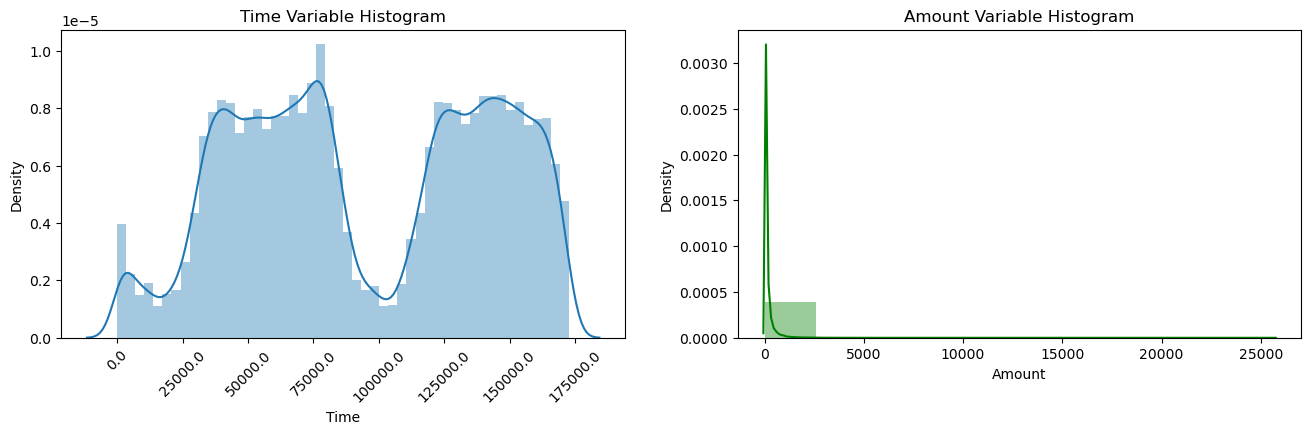

In [6]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 4))
ax0.set_title("Time Variable Histogram")
sns.distplot(df["Time"], bins=50, ax=ax0)
ax0.set_xticklabels(ax0.get_xticks(), rotation=45)

ax1.set_title("Amount Variable Histogram")
sns.distplot(df["Amount"], bins=10, color="g", ax=ax1)
fig.show()

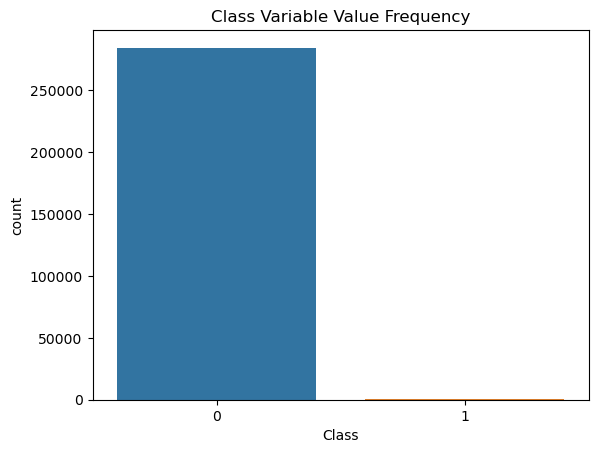

In [7]:
plt.title("Class Variable Value Frequency")
sns.countplot(data=df, x="Class")
plt.show()

In [8]:
df["Class"].value_counts().to_frame().join(
    (df["Class"].value_counts(normalize=True).to_frame() * 100).round(3),
    lsuffix="Count",
    rsuffix="Freq%"
)

,ClassCount,ClassFreq%
0,284315,99.827
1,492,0.173


## <span id="3"></span>3. Feature Extraction and Scaling

The 'V's variables are the product of scaling and dimensionality reduction (PCA) applied by the dataset owners for confidentiality reasons. Only the variables _Amount_ and _Time_ were untouched, so we will need to apply some scaling before using them in model training/testing.

The _Time_ variable contains the seconds elapsed between each transaction and the first transaction in the dataset. If we had access to the original dataset, we probably would be able to create new features based in the transaction time, such as the hour of the day the transaction occured. Knowing the dataset contains transaction data from two days of September 2013 and taking into account the distribution of the _Time_ variable, we can estimate that the first transaction recorded (with Time value of 0) was originally emitted in the initial hours of the first recording day. In this scenario, we will be creating an estimated feature (_Time_Day_Hour_) from the _Time_ variable, indicating the hour of day for each transaction.

In [9]:
day_sec = df["Time"] % (24 * 60 * 60)
day_hour = day_sec // (60 * 60)
df["Time_Day_Hour"] = day_hour.astype(np.int8)
df.drop("Time", axis=1, inplace=True)

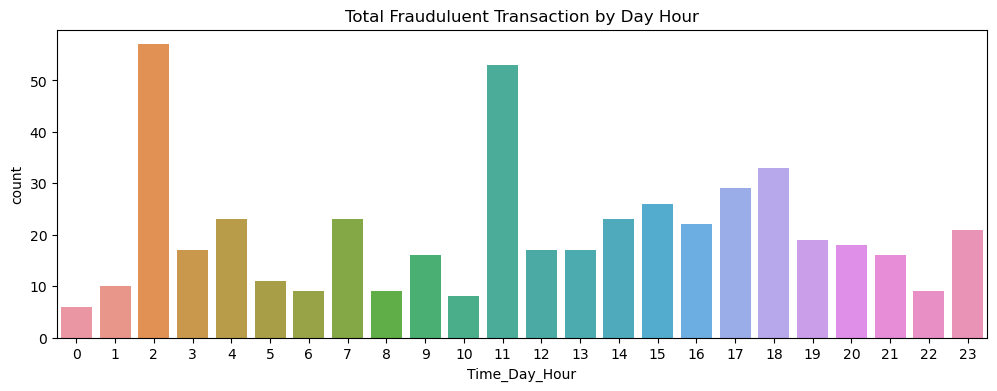

In [10]:
plt.figure(figsize=(12, 4))
plt.title("Total Frauduluent Transaction by Day Hour")
sns.countplot(data=df.loc[df["Class"] == 1], x="Time_Day_Hour")
plt.show()

In [11]:
scaler = StandardScaler()
df["Amount_sc"] = scaler.fit_transform(df["Amount"].values.reshape(-1, 1))
df["DayHour_sc"] = scaler.fit_transform(df["Time_Day_Hour"].values.reshape(-1, 1))
df.drop(["Time_Day_Hour", "Amount"], axis=1, inplace=True)

## <span id="4"></span>4. Correlation Analysis

Because of the data processing performed by the dataset owners, we cannot tell much about the correlation between the independent variables. What we will be analyzing in this section is the correlation between the PCA variables (the "V" ones) and the target variable ("Class").

**Note:** we are dealing with a extremely imbalanced dataset, so we need to perform some undersampling before analyzing the correlation between the predictor variables and the target.

In [12]:
df_corr = df.sample(frac=1., random_state=seed) # shuffle the data before resampling

# split the data by Class value
frauds = df_corr.loc[df_corr["Class"] == 1]
non_frauds = df_corr.loc[df_corr["Class"] == 0].iloc[:len(frauds)]

df_corr = pd.concat((frauds, non_frauds)).sample(frac=1., random_state=seed)
df_corr["Class"].value_counts().sort_index()

0    492
1    492
Name: Class, dtype: int64

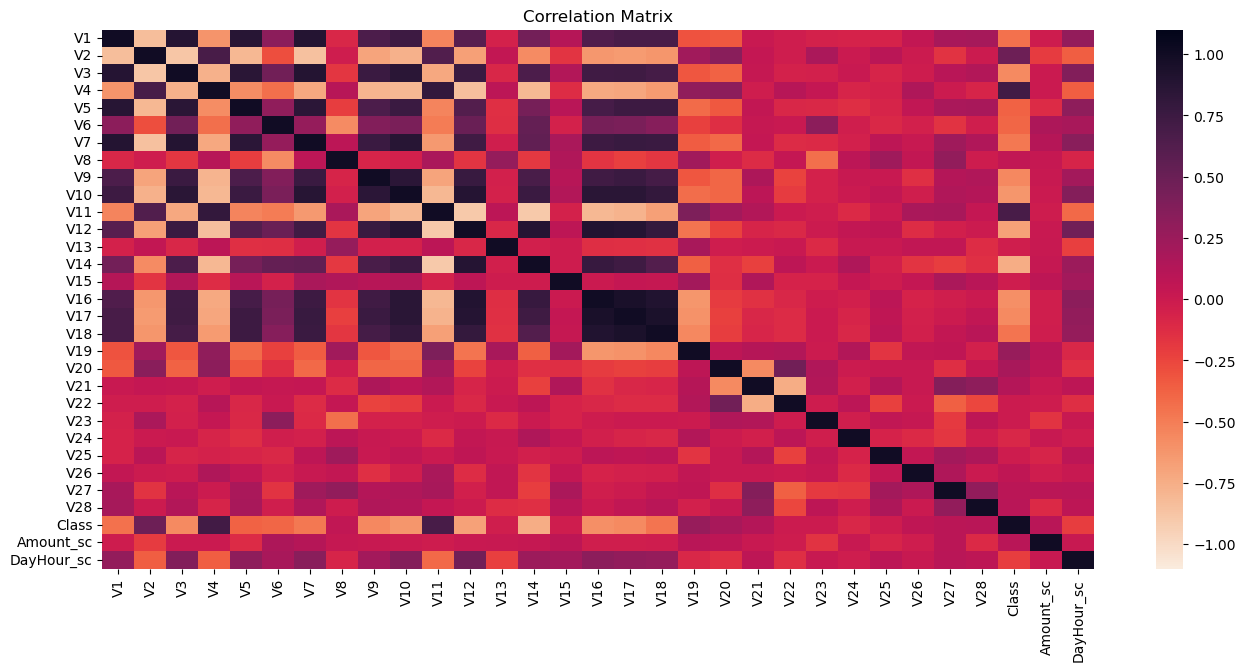

In [13]:
corr = df_corr.corr()
plt.figure(figsize=(16, 7))
plt.title("Correlation Matrix")
sns.heatmap(corr, cmap="rocket_r", annot=False, cbar=True, vmin=-1.1, vmax=1.1)
plt.show()

In [14]:
top_corrs = corr.loc[corr["Class"].abs() >= 0.5]["Class"].drop("Class").sort_values()
top_corrs

V14   -0.746894
V12   -0.684177
V10   -0.624654
V16   -0.586861
V3    -0.562017
V17   -0.559102
V9    -0.557562
V11    0.686410
V4     0.719717
Name: Class, dtype: float64

From the correlation matrix above, we can see that some variables are highly correlated with the Class variable.
- **Positive Correlations:** V11, V4
- **Negative Correlation:** V14, V12, V10, V16, V3, V17, V9

Now that we know these variables are correlated with our target variable, let's explore their individual impact in the targets values (fraud/non-fraud).

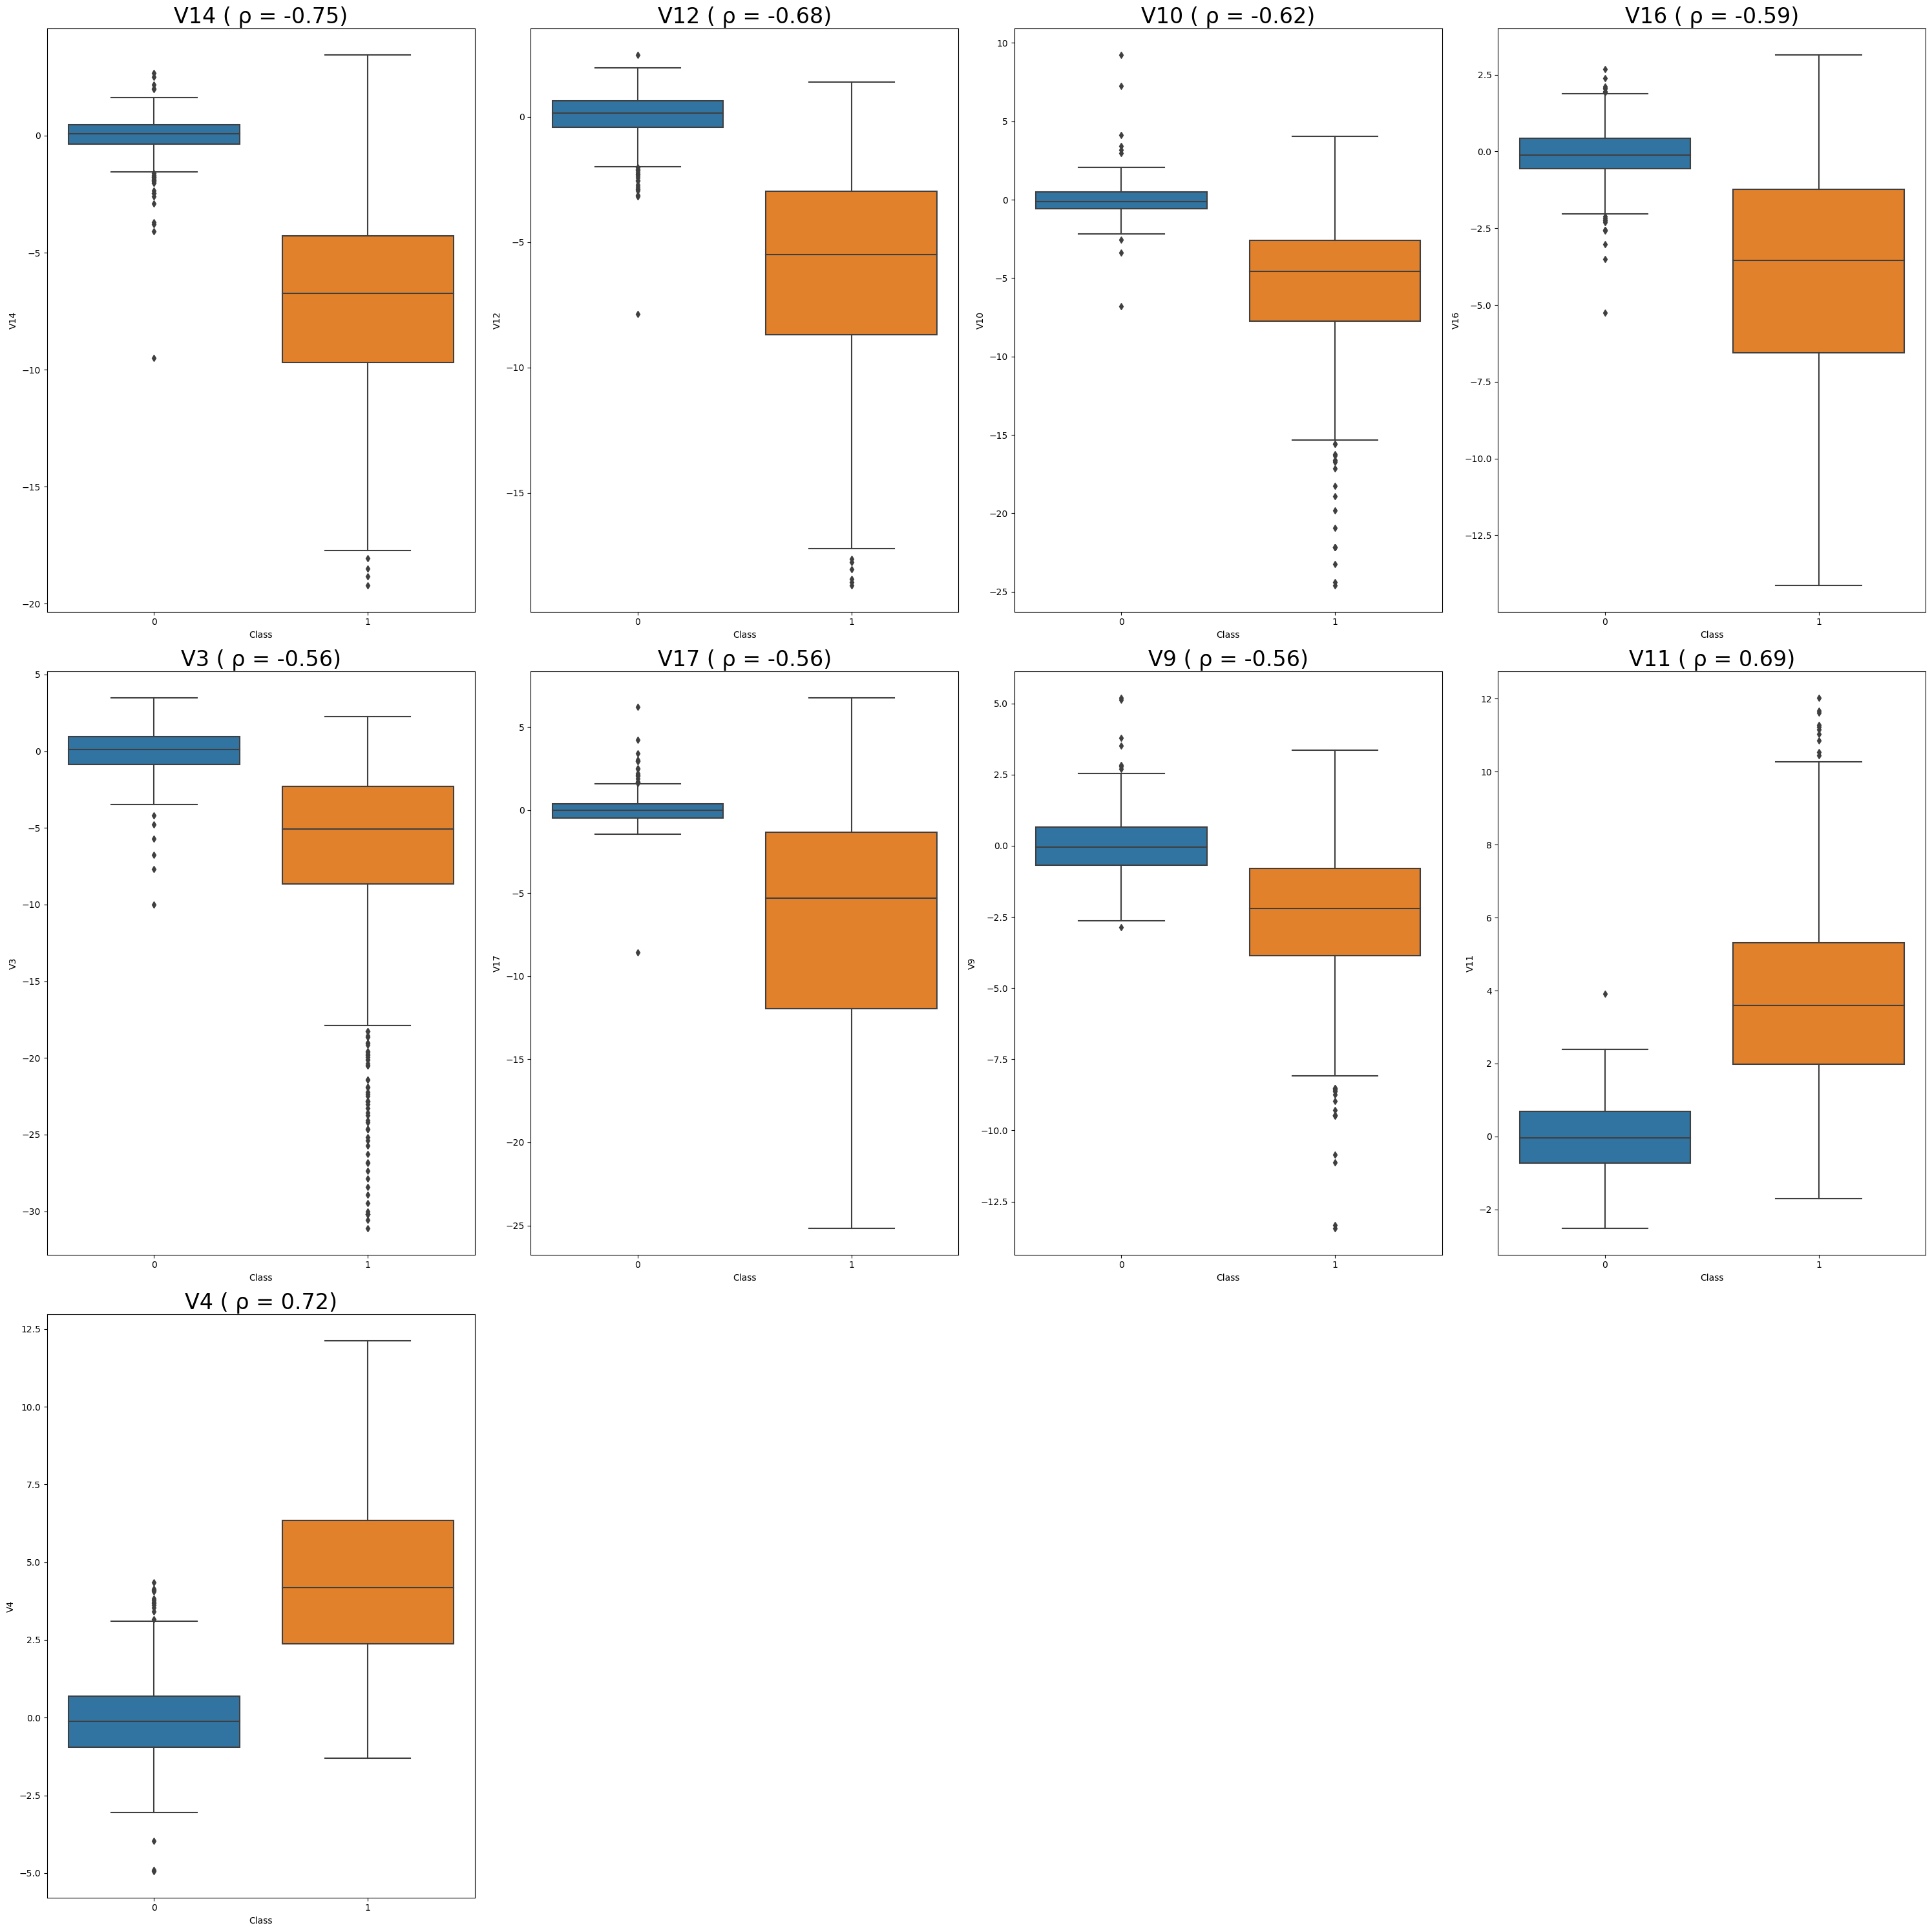

In [15]:
n_rows = math.ceil(len(top_corrs) / 4)

fig, axes = plt.subplots(n_rows, 4, figsize=(30, 30))

for i, var in enumerate(top_corrs.index.values):
    ax = axes[i // 4][i % 4]
    ax.set_title(f"{var} ( ρ = {np.round(top_corrs[var], 2)})", fontdict=dict(fontsize=24))
    sns.boxplot(data=df_corr, x="Class", y=var, ax=ax)

# removing unused Axes
i += 1
while i < (n_rows * 4):
    axes[i // 4][i % 4].remove()
    i += 1
    
plt.tight_layout()
plt.show()

Despite the fact that we don't really know what each of the Vs variables represents, from the _boxplots_ above we can see that the some of them have different statistical properties (means and variances) in their distributions when compared relatively to the Class variable. This may be an indication that these variables have statistical significance to the classification task.
It can be observed that some of the variables above have some anomalies, also known as **outliers**, most of them being of the fraud class. The presence of some of them can make our models to capture wrong patterns, so their removal can, in some cases, increase the classification performance. But this has to be done with care to avoid information loss and, consequently, model _underfitting_.

## <span id="6"></span>6. Fraud Detection

The first thing we need to do is to split our dataset in train and test/validation datasets. Considering our target variable imbalanced nature, we need to make use of a stratified sampling strategy.

In [16]:
X = df.drop("Class", axis=1)
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True, random_state=seed)
print(f"X_train: {X_train.shape}\nX_test: {X_test.shape}")

X_train: (213605, 30)
X_test: (71202, 30)


Our training dataset contains a lot of records and using the entire dataset to train the models can take much time. Therefore, we will apply random undersampling in order to obtain a smaller and balanced training set that we will use to select the best models and hyperparams.

In [17]:
samples = pd.concat((X_train, y_train), axis=1).sample(frac=1., random_state=seed)
frauds = samples.loc[samples["Class"] == 1]
non_frauds = samples.loc[samples["Class"] == 0].iloc[:len(frauds)]
undersample = pd.concat((frauds, non_frauds))
undersample = undersample.sample(frac=1., random_state=seed)
undersample["Class"].value_counts()
X_train_undersample = undersample.drop("Class", axis=1).values
y_train_undersample = undersample["Class"].values
print(X_train_undersample.shape)

(738, 30)


With the undersampled dataset, let's train and test the following models...

In [18]:
classifiers = [
    LogisticRegression(max_iter=300, random_state=seed),
    KNeighborsClassifier(),
    DecisionTreeClassifier(),
    SVC(max_iter=1e5, random_state=seed),
    RandomForestClassifier(random_state=seed)
]

In [19]:
for clf in classifiers:
    scores = cross_val_score(
        clf,
        X_train_undersample,
        y_train_undersample,
        scoring="roc_auc",
        cv=5,
        n_jobs=5
    )
    
    print(f"{clf.__class__.__name__}: {np.round(np.mean(scores), 5)}")

LogisticRegression: 0.97154
KNeighborsClassifier: 0.96946
DecisionTreeClassifier: 0.87938
SVC: 0.97646
RandomForestClassifier: 0.97595


Now that we have a baseline model for each of the proposed machine learning models, we will use GridSearchCV to find the best combination of model hyperparams that maximizes its performance.

In [20]:
lr_gs = GridSearchCV(
    classifiers[0],
    param_grid={
        "penalty": ["l1", "l2"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000]
    },
    scoring="roc_auc",
    cv=5
)

knn_gs = GridSearchCV(
    classifiers[1],
    param_grid={
        "p": [1, 2],
        "n_neighbors": np.arange(4, 10, 1)
    },
    scoring="roc_auc",
    cv=5
)

dt_gs = GridSearchCV(
    classifiers[2],
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": np.arange(2, 5, 1),
    },
    scoring="roc_auc",
    cv=5
)

svc_gs = GridSearchCV(
    classifiers[3],
    param_grid={
        "kernel": ["linear", "poly", "sigmoid", "rbf"],
        "C": [0.001, 0.01, 0.1, 1, 10, 100, 1000],
        "degree": np.arange(1, 6)
    },
    scoring="roc_auc",
    cv=5
)

rf_gs = GridSearchCV(
    classifiers[4],
    param_grid={
        "criterion": ["gini", "entropy", "log_loss"],
        "max_depth": np.arange(2, 5, 1),
    },
    scoring="roc_auc",
    cv=5
)

gss = (lr_gs, knn_gs, dt_gs, svc_gs, rf_gs)

for gs in gss:
    gs.fit(X_train_undersample, y_train_undersample)
    print(f"{gs.estimator.__class__.__name__}: {np.round(np.mean(gs.best_score_), 5)}")
    
best_models = [gs.best_estimator_ for gs in gss]

LogisticRegression: 0.9744
KNeighborsClassifier: 0.97693
DecisionTreeClassifier: 0.94724
SVC: 0.97677
RandomForestClassifier: 0.9759


We can observe that the score (accuracy) of each model increased when we performed hyperparameter tuning, so we will use the obtained parameter combinations in the following steps.

To train and test our final models, we will use the entire training set, but as we know, it is highly imbalanced. So we will build Pipelines that runs **SMOTE** (an oversampling strategy) before fitting the model. SMOTE will insert new instances of the undersampled class (fraud transactions) to the training set, solving the imbalancement problem.

In [21]:
pipes = [Pipeline((
    ("oversample", SMOTE(sampling_strategy=0.3, k_neighbors=9, random_state=seed)),
    ("classifier", clf)
)) for clf in best_models]

for pipe in pipes:
    scores = cross_val_score(
        pipe,
        X_train,
        y_train,
        scoring="roc_auc",
        cv=5,
        n_jobs=5
    )
    
    print(f"{pipe.steps[-1][1].__class__.__name__}: {np.round(np.mean(scores), 5)}")

LogisticRegression: 0.97903
KNeighborsClassifier: 0.93559
DecisionTreeClassifier: 0.95333
SVC: 0.948
RandomForestClassifier: 0.97516


In [22]:
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    
    return accuracy, auc, precision, recall, f1, cm

models_names = []
accuracy_scores = []
aucs = []
precision_scores = []
recall_scores = []
f1_scores = []
cms = []

for pipe in pipes:
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    accuracy, auc, precision, recall, f1, cm = metrics(y_test, preds)
    models_names.append(pipe.steps[-1][1].__class__.__name__)
    accuracy_scores.append(accuracy)
    aucs.append(auc)
    precision_scores.append(precision)
    recall_scores.append(recall)
    f1_scores.append(f1)
    cms.append(cm)
    
pd.DataFrame(data=list(zip(accuracy_scores, aucs, precision_scores, recall_scores, f1_scores)), index=models_names, columns=["Accuracy", "ROC AUC", "Precision", "Recall", "F1 Score"])

,Accuracy,ROC AUC,Precision,Recall,F1 Score
LogisticRegression,0.992121,0.947358,0.168182,0.902439,0.283525
KNeighborsClassifier,0.996910,0.933524,0.344051,0.869919,0.493088
DecisionTreeClassifier,0.994242,0.936246,0.214712,0.878049,0.345048
SVC,0.997739,0.893359,0.418103,0.788618,0.546479
RandomForestClassifier,0.999214,0.934678,0.727891,0.869919,0.792593


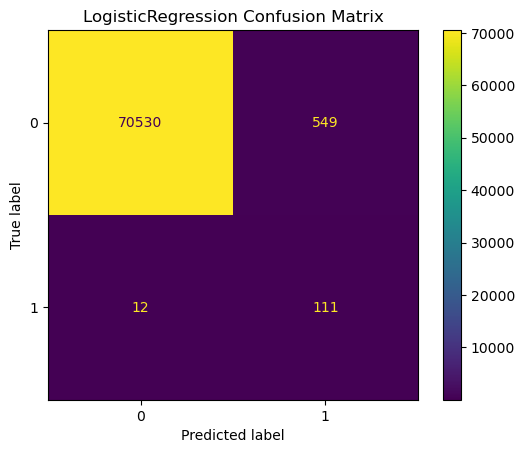

In [23]:
ConfusionMatrixDisplay(cms[0]).plot()
plt.title("LogisticRegression Confusion Matrix")
plt.show()

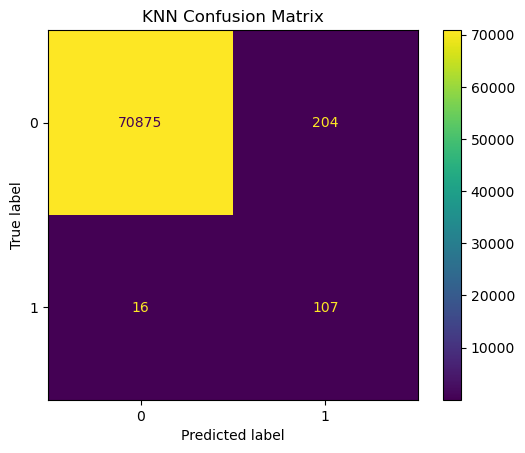

In [24]:
ConfusionMatrixDisplay(cms[1]).plot()
plt.title("KNN Confusion Matrix")
plt.show()

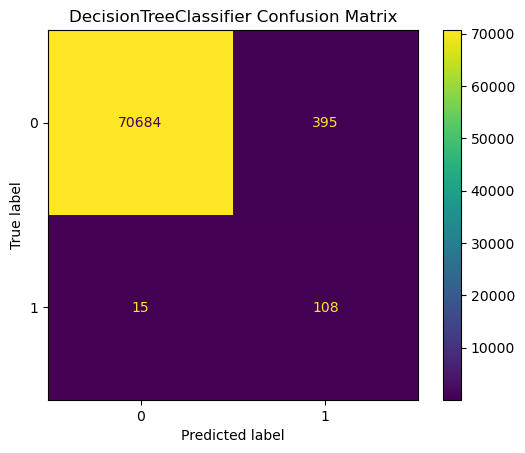

In [25]:
ConfusionMatrixDisplay(cms[2]).plot()
plt.title("DecisionTreeClassifier Confusion Matrix")
plt.show()

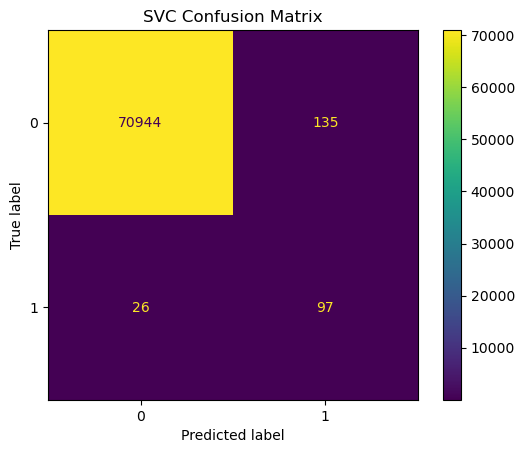

In [26]:
ConfusionMatrixDisplay(cms[3]).plot()
plt.title("SVC Confusion Matrix")
plt.show()

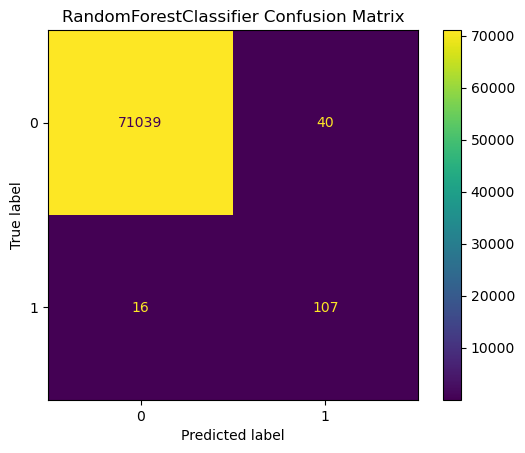

In [27]:
ConfusionMatrixDisplay(cms[4]).plot()
plt.title("RandomForestClassifier Confusion Matrix")
plt.show()